In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from data_load import load_data
import glob

c:\Users\kiemd\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# chargement des donnees

In [2]:
dfs,images=load_data('./data/data_conta.csv')

In [3]:
len(images)

5795

In [4]:
df=pd.read_csv('./data/data_csv/data_vrai.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Nom             5808 non-null   object
 1   prix            5808 non-null   int64 
 2   link            5808 non-null   object
 3   marque          5808 non-null   object
 4   Description     5808 non-null   object
 5   modele          5808 non-null   object
 6   couleur         5808 non-null   object
 7   cathegorie      5808 non-null   object
 8   identification  5808 non-null   int64 
 9   file_name       5808 non-null   object
dtypes: int64(2), object(8)
memory usage: 453.9+ KB


# Nettoyage de donne text

In [21]:
df.duplicated().sum()

0

In [22]:
df.isnull().sum()

Nom               0
prix              0
link              0
marque            0
Description       0
modele            0
couleur           0
cathegorie        0
identification    0
file_name         0
infos             0
dtype: int64

In [23]:
df.dropna(inplace=True)

In [24]:
df.isnull().sum()

Nom               0
prix              0
link              0
marque            0
Description       0
modele            0
couleur           0
cathegorie        0
identification    0
file_name         0
infos             0
dtype: int64

# concatenation des colonne

In [11]:
df['infos']=df['Nom']+df['couleur']+df['marque']+df['modele']+df['cathegorie']

# data cleaning

In [12]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
def clean_data(df,colomns):
    stop_words = set(stopwords.words('french'))
    stemmer = SnowballStemmer('french')
    df.dropna()
    # Suppression de tout ce qui n'est pas alphabet français
    df[colomns] = df[colomns].str.replace('[^a-zA-ZÀ-ÿ]', ' ', regex=True)
    # Suppression des espaces multiples en début et fin de lignes
    df[colomns] = df[colomns].str.replace('^\s+\s+$', ' ', regex=True)
    # Suppression des espaces multiples dans le texte
    df[colomns] = df[colomns].str.replace('\s+', ' ', regex=True)
    # Suppression des caractères html
    df[colomns] = df[colomns].str.replace('&\w+', '', regex=True)
    # Transformation de majuscule en minuscule
    df[colomns] = df[colomns].str.lower()
    # Normalisation des caractères accentués
    #df['infos'] = df['infos'].apply(lambda x: unidecode(x))
    # Suppression des stopwords en français et lemmatisation
    df[colomns] = df[colomns].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x) if word.lower() not in stop_words and len(word) > 2]))
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kiemd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kiemd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
categorie_counts = df['cathegorie'].value_counts()
print(categorie_counts)


cathegorie
beaute-hygiene-sante                    1570
electronique                            1564
telephone-tablette                      1352
ordinateurs-accessoires-informatique    1322
Name: count, dtype: int64


In [14]:
df_text=clean_data(df,'infos')

In [33]:
df_text['infos'][1]

'nov gel douch classic mljumi mallnov beaut hygien sant'

# Modele clip texte image


In [20]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm


In [15]:
text=df['infos'][1]
print(text)

nov gel douch classic mljumi mallnov beaut hygien sant


In [16]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_images(images,scores, n_row=2, n_col=2):
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, score, ax in zip(images, scores, axs):
        ax.set_title(f"Similarity: {score*100:.2f}%")
        ax.imshow(img)
    plt.show()
    


# modele image normaliser

In [81]:
from PIL import Image
import numpy as np
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt  # Assuming you have a function like plot_images

def plot_image(images, query, scores, n_row=2, n_col=2):
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, score, ax in zip(images, scores, axs):
        ax.set_title(f"Similarity: {score*100:.2f}%")
        
        # Convertir l'objet Image en tableau NumPy
        img_array = np.array(img)
        
        # Afficher l'image
        ax.imshow(img_array)
    plt.show()




def normalize_and_resize_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = Image.open(path)
        img = np.array(img) / 255.0
        img = Image.fromarray((img * 255).astype(np.uint8))
        img = img.resize(target_size, Image.BILINEAR)
        images.append(path)  # Modification ici pour ajouter le chemin au lieu de l'objet Image
    return images


def calculate_similarity(text, image_data, model_id="clip-ViT-B-32-multilingual-v1", top_k=5):
    # Utilisation du modèle SentenceTransformers
    model = SentenceTransformer(model_id)
    
    # Encodage du texte
    text_embedding = model.encode([text], convert_to_tensor=True)

    # Encodage des images dans la base de données
    image_embeddings = model.encode([np.array(img) for img in image_data], batch_size=128, convert_to_tensor=True, show_progress_bar=True)
    
    # Calcul de la similarité
    scores = util.pytorch_cos_sim(text_embedding, image_embeddings)[0].cpu().detach().numpy()

    # Récupération des indices des images les plus similaires
    top_indices = np.argsort(-scores)[:top_k]
    
    # Tri des indices en fonction des scores de similarité
    sorted_indices = sorted(top_indices, key=lambda x: scores[x], reverse=True)
    
    # Affichage des résultats
    matched_images = [Image.fromarray(image_data[idx]) for idx in top_indices]
    
    # Extraction des noms de fichiers correspondants
    matched_image_names = [image_data[idx] for idx in top_indices]
    for i in  matched_image_names:
        print(i)
    plot_image(matched_images, text, scores)
    return sorted_indices, scores, matched_images, matched_image_names


In [74]:
images[0]

'./data1_image\\beaute-hygiene-sante\\0_Generic_Tondeuse_HTC_pour_Barbe_et_t_te_professionnelle__-_AT_206.jpg'

In [75]:
text=df['infos'][1]

In [76]:
print(text)

nov gel douch classic mljumi mallnov beaut hygien sant


In [77]:

calculate_similarity(text, images, top_k=5)

TypeError: len() of unsized object

# Best model

In [22]:
def plot_images(images, query, scores, n_row=2, n_col=2):
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, score, ax in zip(images, scores, axs):
        ax.set_title(f"Similarity: {score*100:.2f}%")
        ax.imshow(img)
    plt.show()


In [36]:
def calculate_similarity(text, image_data, model_id="clip-ViT-B-32-multilingual-v1", top_k=5):
    # Utilisation du modèle SentenceTransformers 
    model = SentenceTransformer(model_id)
    
    # Encodage du texte
    text_embedding = model.encode([text], convert_to_tensor=True)

    # Encodage des images dans la base de données
    image_embeddings = model.encode([str(filepath) for filepath in image_data], batch_size=500, convert_to_tensor=True, show_progress_bar=True)
    

    
    print("Text Embedding Shape:", text_embedding.shape)
    print("Image Embeddings Shape:", image_embeddings.shape)

    # Calcul de la similarité
    scores = util.pytorch_cos_sim(text_embedding, image_embeddings)[0].cpu().detach().numpy()
    #scores = util.pytorch_cos_sim(text_embedding,  image_embeddings).cpu().detach().numpy().flatten()
    # Affichage des scores
    print("Scores:", scores)
    # Affichage des résultats


    # Récupération des indices des images les plus similaires
    top_indices = np.argsort(-scores)[:top_k]
    
    #Tri des indices en fonction des scores de similarité
    sorted_indices = sorted(top_indices, key=lambda x: scores[x], reverse=True)
    # Affichage des résultats
    matched_images = [Image.open(image_data[idx]) for idx in  top_indices]
    matched_images = [Image.open(image_data[idx]) for idx in top_indices]
    print("Matched Image Names:", matched_image_names)


# Pour sauvegarder
    # Pour charger
    image_embeddings_loaded = torch.from_numpy(np.load("precomputed_image_embeddings.npy"))
    print("Image Embeddings Shape after loading:", image_embeddings_loaded.shape)


    # Extraction des noms de fichiers correspondants
    matched_image_names = [image_data[idx] for idx in sorted_indices]
    
    plot_images(matched_images, text,  scores )
    return  sorted_indices, scores, matched_images, matched_image_names


In [37]:
text=df['infos'][1]
print(text)

nov gel douch classic mljumi mallnov beaut hygien sant


In [38]:

sorted_indices, scores, matched_images, matched_image_names=calculate_similarity(text, images, top_k=5)
# Access matched image names
print("Matched Image Names:")
for name in matched_image_names:
    print(name)

Batches: 100%|██████████| 12/12 [03:38<00:00, 18.17s/it]

Text Embedding Shape: torch.Size([1, 512])
Image Embeddings Shape: torch.Size([5795, 512])
Scores: [0.9260046  0.9307508  0.91790354 ... 0.8967378  0.9031612  0.8937442 ]


UnboundLocalError: cannot access local variable 'matched_image_names' where it is not associated with a value

In [29]:
# Avant la sauvegarde



NameError: name 'image_embeddings' is not defined

In [58]:
matched_image_names[0]

'./data1_image\\beaute-hygiene-sante\\219_Generic_Pack_de_3_Bonnets_En_Satin_Pour_Femme.jpg'

In [59]:
df['Nom'][3524]

'Cable Computer Cable USB 2.0 pour imprimante'

In [272]:
sorted_indices

[3519, 4192, 4279, 4114, 3362]

# link

In [60]:
def link_image(matched_image_names):
    import re

    # Pattern regex pour le préfixe à supprimer
    prefix_pattern = re.compile(r'./data1_image\\[a-zA-Z_-]+\\')

    # Pattern regex pour capturer la séquence de chiffres
    number_pattern = re.compile(r'(\d+)')

    # Liste pour stocker les chiffres extraits
    numbers = []

    # Boucle sur tous les liens
    for path in matched_image_names:
        # Utiliser la regex pour supprimer le préfixe spécifié
        path_without_prefix = re.sub(prefix_pattern, '', path)
        
        # Utiliser la regex pour extraire la séquence de chiffres
        match = re.search(number_pattern, path_without_prefix)
        
        if match:
            # Récupérer le nombre trouvé dans le groupe correspondant
            number = int(match.group(1))
            numbers.append(number)
        else:
            # Ajouter une valeur par défaut ou signaler une absence de nombre
            numbers.append(None)

    # Imprimer les chiffres extraits
    print("Chiffres extraits :", numbers)

    # Retourner la liste complète de chiffres
    return numbers

# Exemple d'utilisation
matched_image_names = matched_image_names
numbers = link_image(matched_image_names)
print("Résultats finaux :", numbers)


Chiffres extraits : [219, 71, 114, 3631, 4625]
Résultats finaux : [219, 71, 114, 3631, 4625]


In [61]:
scores

array([0.8990558 , 0.8990558 , 0.89909035, ..., 0.8990558 , 0.8990558 ,
       0.8990558 ], dtype=float32)

In [280]:
df['Nom'][3524]

'Cable Computer Cable USB 2.0 pour imprimante'

Number: 3524 Score: 0.864012598991394
Product Name: Cable Computer Cable USB 2.0 pour imprimante


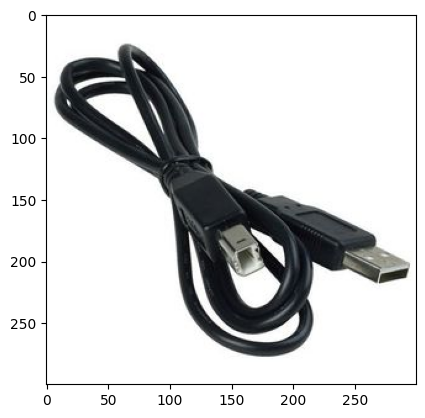

Number: 4202 Score: 0.8610512018203735
Product Name: Generic Support 100% Aluminium pour ordinateur portable - Gris


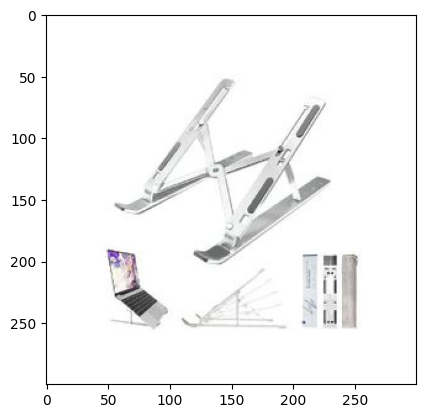

Number: 4292 Score: 0.8578964471817017
Product Name: Generic Laptop Support ordinateur plastique dur


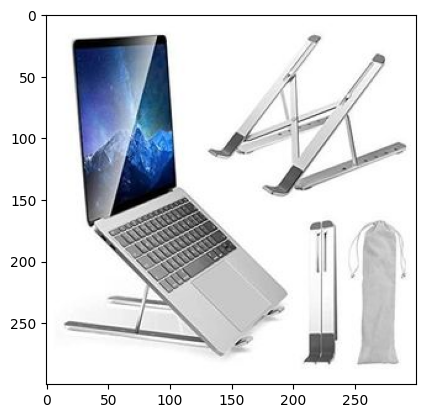

Number: 4123 Score: 0.8622380495071411
Product Name: Cable Computer Cable USB 2.0 pour imprimante


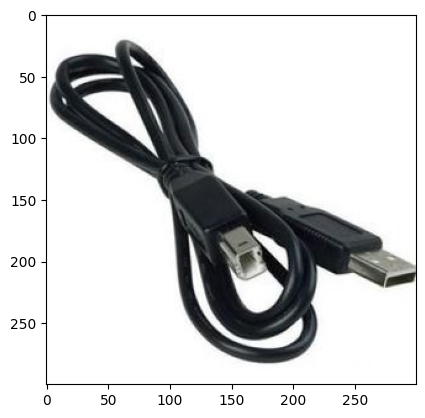

Number: 3366 Score: 0.8836245536804199
Product Name: Generic Laptop Support ordinateur plastique dur


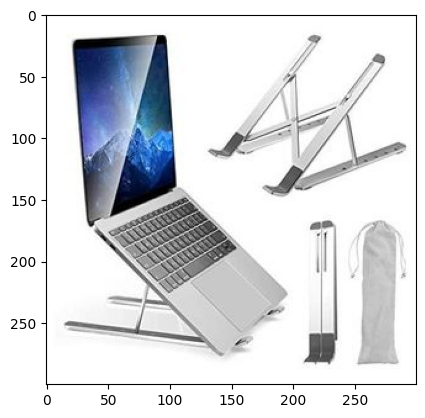

In [293]:
import matplotlib.pyplot as plt

for i in range(len(numbers)):
    print(f'Number: {numbers[i]} Score: {scores[i]}')
    print(f'Product Name: {df["Nom"][numbers[i]]}')
    
    # Assurez-vous que matched_images est une liste d'images
    # Si c'est une liste d'images PIL, vous pouvez l'afficher avec plt.imshow
    plt.imshow(matched_images[i])
    plt.show()


# Modele clip image a text

In [116]:
def clip_image_text(reference_image_path, image_data, model_id="clip-ViT-B-32-multilingual-v1", top_k=5):
    # Utilisation du modèle SentenceTransformers
    model = SentenceTransformer(model_id)

    # Encodage de l'image de référence
    reference_image_embedding = model.encode([str(reference_image_path)], convert_to_tensor=True)

    # Encodage des images dans la base de données
    image_embeddings = model.encode([str(filepath) for filepath in image_data], batch_size=500, convert_to_tensor=True, show_progress_bar=True)
    #image_embeddings=np.load("precomputed_image_embeddings.npy")
    # Calcul de la similarité entre l'image de référence et les autres images
    similarity_scores = util.pytorch_cos_sim(reference_image_embedding, image_embeddings).cpu().detach().numpy().flatten()

    # Récupération des indices des images les plus similaires
    top_indices = np.argsort(-similarity_scores)[:top_k]

    # Tri des indices en fonction des scores de similarité
    sorted_indices = sorted(top_indices, key=lambda x: similarity_scores[x], reverse=True)

    # Affichage des résultats
    matched_images = [Image.open(image_data[idx]) for idx in top_indices]

    # Extraction des noms de fichiers correspondants
    matched_image_names = [image_data[idx] for idx in top_indices]
    plot_images(matched_images, similarity_scores[:top_k])
    return sorted_indices, similarity_scores, matched_images, matched_image_names


In [117]:
def plot_images(images,scores, n_row=2, n_col=2):
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, score, ax in zip(images, scores, axs):
        ax.set_title(f"Similarity: {score*100:.2f}%")
        ax.imshow(img)
    plt.show()

Batches: 100%|██████████| 12/12 [04:55<00:00, 24.65s/it]


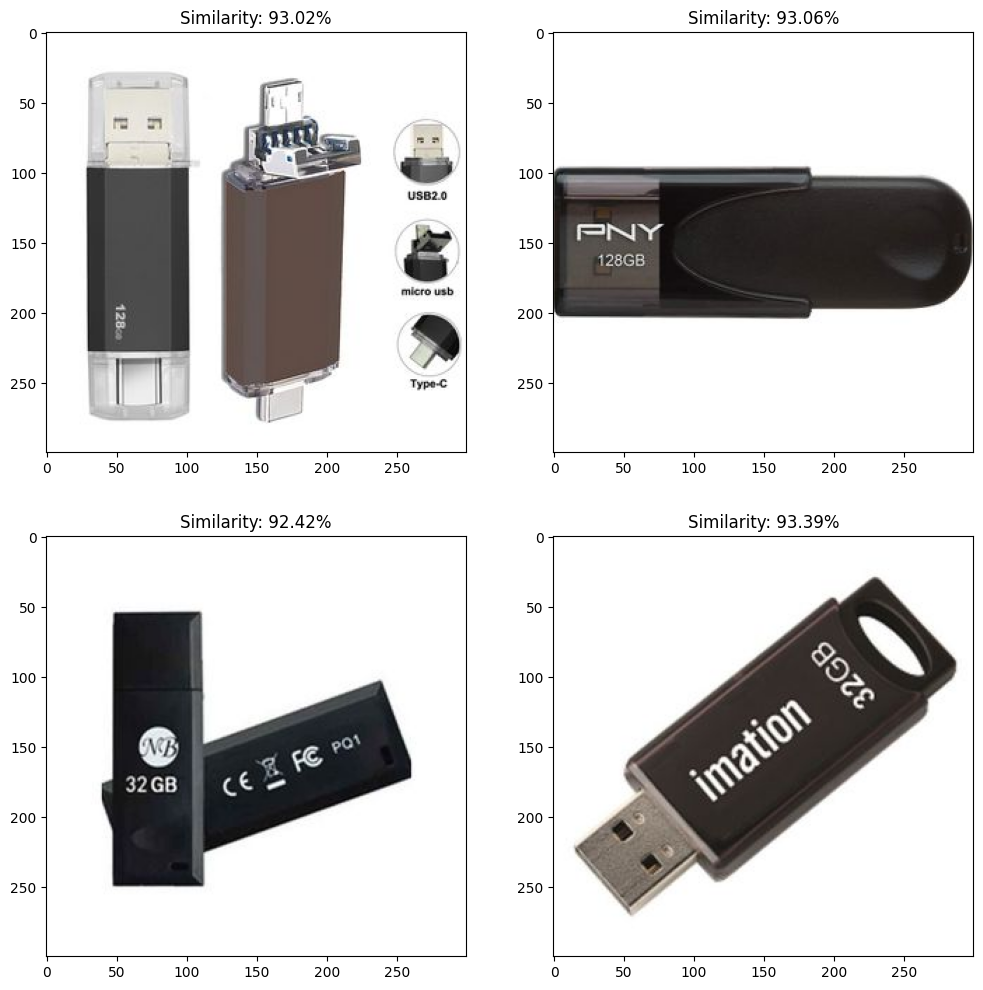

In [118]:
# Exemple d'utilisation
reference_image_path = "./data1_image/ordinateurs-accessoires-informatique/3135_Generic_Cl__OTG_128_Go__USB_Type_C_-_Noir.jpg"
#list_of_images = ["chemin/vers/image1.jpg", "chemin/vers/image2.jpg", "chemin/vers/image3.jpg"]
sorted_indices, similarity_scores, matched_images, matched_image_names = clip_image_text(reference_image_path, images)




In [107]:
matched_image_names = matched_image_names
numbers = link_image(matched_image_names)
print("Résultats finaux :", numbers)


Chiffres extraits : [3138, 4396, 3135, 3217, 3213]
Résultats finaux : [3138, 4396, 3135, 3217, 3213]


Number: 3138 Score: 0.8990557789802551
Product Name: General 2 En 1 Clé USB - OTG 128Go - Tête Type C Offert - Violet


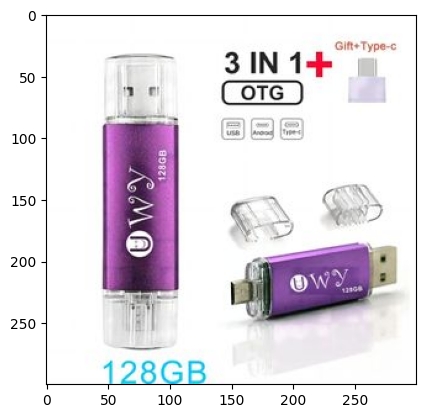

Number: 4396 Score: 0.8990557789802551
Product Name: Generic Clé USB 64 Go + Clé USB 16 Go pour TV - Gris / Violet


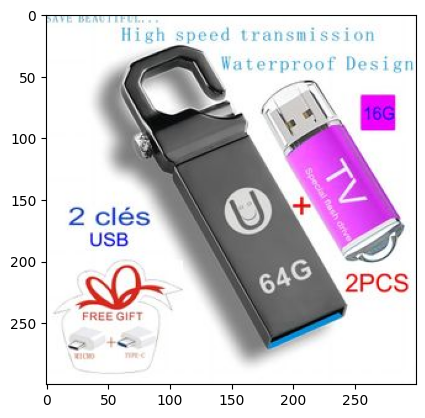

Number: 3135 Score: 0.8990903496742249
Product Name: Generic Clé OTG 128 Go  USB Type C - Noir


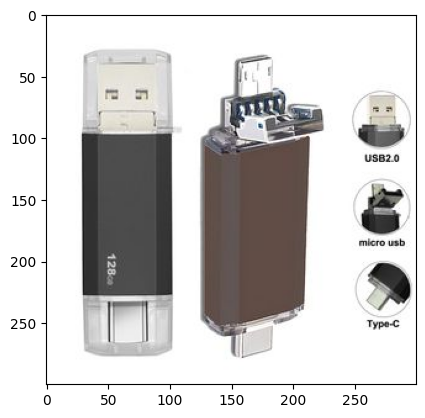

Number: 3217 Score: 0.8990557789802551
Product Name: Generic Clé USB  -128Go-Argent


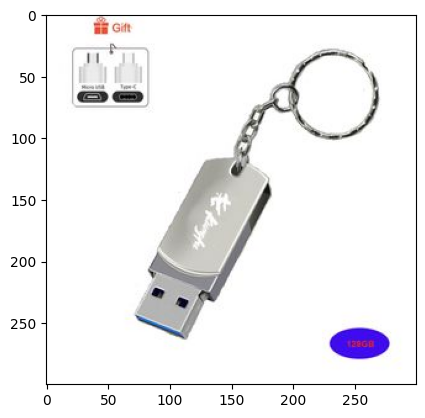

Number: 3213 Score: 0.90953528881073
Product Name: Generic Adaptateur OTG Type-C mâle vers USB 3.1 femelle COULEUR BLANCHE


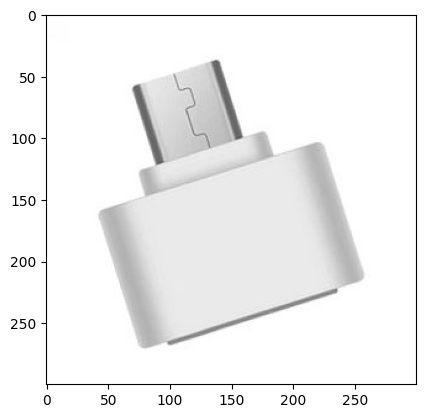

In [108]:
import matplotlib.pyplot as plt

for i in range(len(numbers)):
    print(f'Number: {numbers[i]} Score: {scores[i]}')
    print(f'Product Name: {df["Nom"][numbers[i]]}')
    
    # Assurez-vous que matched_images est une liste d'images
    # Si c'est une liste d'images PIL, vous pouvez l'afficher avec plt.imshow
    plt.imshow(matched_images[i])
    plt.show()


# Test avec le modele 